In [1]:
###Libraries (not in function files)
from sklearn.model_selection import train_test_split
import scipy
from dscribe.descriptors import SOAP, ACSF

In [2]:
from project_dataload import data_load, check_data, summarize_1
from project_gaussian import *
from Fingerprints import Sinemats, Coulombmatrices, Ewaldsummatrices
from PCA_decomposition import *
from GP import GP
from GP_optimizable import GP_opt

In [3]:
### rmse
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [4]:
###Data load and check
data_dir="./project_data/"
train, test = data_load(data_dir)

print('Check train data')
check_data(train)
print('Check test data')
check_data(test)
summary = summarize_1(train, test)
print('Max number of atoms',summary['max_number_of_atoms'])


Check train data
Train data shape: (8000, 4)
     id        formula                                              atoms  \
0  5154         Zr2BO2  (Atom('Zr', [1.6878604657, 0.892285133, 8.1345...   
1   984          Ni2S6  (Atom('Ni', [1.1571403137, 0.934725185, 12.234...   
2  1634  Cd4K2Cl6O6Te2  (Atom('Cd', [2.7840261751, 5.6922402759, 26.71...   
3  1872      Hf4H2N3O2  (Atom('Hf', [0.0, 1.8677827772, 12.2421466347]...   
4  2977         Sc2Te2  (Atom('Te', [0.0003850118, 0.0002469812, 7.461...   

      hform  
0 -2.037877  
1 -0.091020  
2 -1.109751  
3 -1.609142  
4 -0.854593  
Check test data
Train data shape: (4000, 3)
      id     formula                                              atoms
0   8538    HfZrSTe2  (Atom('S', [-1.0327079693, 4.2080182974, 22.81...
1   9052    Nb2P2Te6  (Atom('Nb', [0.3517632032, -0.2042419274, 9.20...
2  10503  Au2InI2Se2  (Atom('Se', [0.2238411856, 0.8131388722, 26.83...
3    611   AuTlO6Sb2  (Atom('Au', [0.0002076097, -0.0001198635, 16.6...
4   

In [5]:
### Implement fingerprint
max_num_atoms = summary['max_number_of_atoms']
cmats = Coulombmatrices(train, max_num_atoms)
y_vals = train['hform']
print('Shape of cmats', cmats.shape)

0
1000
2000
3000
4000
5000
6000
7000
Shape of cmats (8000, 400)


# SOAP fingerprints

In [6]:
### fingerprints #2

def soapmatrices(train, species, r_cut, n_max, l_max):
    soap = SOAP(
        species=species,
        r_cut=r_cut,
        n_max=n_max,
        l_max=l_max,
        average = 'inner',
    )  

    #Number of features in soap object
    num_feat = soap.get_number_of_features()
    
    soaps = np.zeros((len(train),num_feat))
    for i,atoms in enumerate(train.atoms):
        if i%1000 == 0:
            print(i)
        soaps[i,:] = soap.create(atoms)
    
    return soaps

species = summary['species']
r_cut = 15
n_max = 3
l_max = 3

soaps = soapmatrices(train, species, r_cut, n_max, l_max)

0
1000
2000
3000
4000
5000
6000
7000


In [7]:
#Check outputted matrices
print('Shape of SOAP fingerprint', soaps.shape)
print('sum of arbitrary fingerprint (is it non-zero?)')
print(np.sum(soaps[5000]))

Shape of SOAP fingerprint (8000, 69564)
sum of arbitrary fingerprint (is it non-zero?)
190.03482745841166


# Prepare data for splitting and pca analysis

In [8]:
# Set target and feature vector (and create smaller dataset)
X = pd.DataFrame(data = soaps, index=train.id)
y = pd.DataFrame(train['hform'].values, index = train.id)

X = X.astype('float32')
y = y.astype('float32')

print('X: {}'.format(X.shape))
print('y: {}'.format(y.shape))


X: (8000, 69564)
y: (8000, 1)


In [9]:
# Split 'training' data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=251)
y_test_values = y_test.values  # Extract values as a NumPy array
y_train_values = y_train.values  # Extract values as a NumPy array

#Split training again to have set for hyperparam optimisation
X_train_hyper, X_test_hyper, y_train_hyper, y_test_hyper = train_test_split(X_train, y_train, test_size=0.8, random_state=251)
y_train_hyper_values = y_train_hyper.values  # Extract values as a NumPy array

Shape of split data:  (6400, 69564) (1600, 69564) (6400, 1) (1600, 1)
Shape of split data for hyperparams  (1280, 69564) (1280, 1)


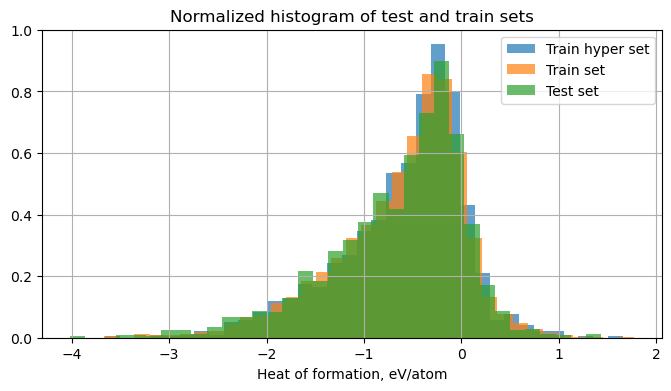

In [10]:
### Check split data
print('Shape of split data: ',X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print('Shape of split data for hyperparams ',X_train_hyper.shape, y_train_hyper.shape)
N_data_PC = X_train_hyper.shape[0]

plt.figure(figsize = (8, 4))
plt.hist(y_train_hyper, bins=35, alpha=0.7, density=True, label='Train hyper set')
plt.hist(y_train, bins=35, alpha=0.7, density=True, label='Train set')
plt.hist(y_test, bins=35, alpha=0.7, density=True, label='Test set')

plt.grid()
plt.title("Normalized histogram of test and train sets")
plt.xlabel("Heat of formation, eV/atom")
plt.legend()
plt.show()

In [37]:
###Principal component decomposition
#Number of components
n_PC = 50

## Standardize the sets by scaling
#Either use X_train (N=6400) or X_train_hyper (N=1280) - make the other only 'transform'
scaler = StandardScaler()
X_train_hyper_scaled = scaler.fit_transform(X_train_hyper)
X_train_scaled = scaler.transform(X_train) 
X_test_scaled = scaler.transform(X_test)  # Scale data

## Apply PCA to the training set
pca = PCA(n_components=n_PC)
X_train_hyper_pca = pca.fit_transform(X_train_hyper_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)  # Use the same PCA

#Check variance and dimensions
print("With {} PCA components {var:0.4f}% of the variance is explained".format(n_PC, var = 100*np.sum(pca.explained_variance_ratio_)))
print('X_train_pca: {}'.format(X_train_pca.shape))
print('X_test_pca: {}'.format(X_test_pca.shape))
print('X_train_hyper_pca: {}'.format(X_train_hyper_pca.shape))

var_PC = 100*np.sum(pca.explained_variance_ratio_)

With 50 PCA components 15.0270% of the variance is explained
X_train_pca: (6400, 50)
X_test_pca: (1600, 50)
X_train_hyper_pca: (1280, 50)


# Training model

In [39]:
### Hard-coded hyperparams
sigma = 0.1
k0 = 1
l= 0.04

In [40]:
# Initiating gaussian process to train hyper params
GP_hyper = GP_opt(X_train_hyper_pca, y_train_hyper)

In [41]:
# Wrapper function to optimize
def optimize_hyper(params):
    GP_hyper.train_GP(params[0], k0, sigma)
    res = GP_hyper.calc_minusloglikelyhood()[0][0] #extract as float, not as pandas
    return res

In [42]:
#Use scipy to optimize
init_guess = [3]
bounds = [(0.01,100)]

optimized_result = scipy.optimize.minimize(optimize_hyper, init_guess, bounds=bounds)


In [43]:
#print results
print("Optimized parameters:", optimized_result.x)
print("Function value at optimum:", optimized_result.fun)
opt_params = [optimized_result.x[0]] # params = [l]
print(opt_params[0])

Optimized parameters: [2.80911171]
Function value at optimum: 1332.84737102143
2.8091117095751312


In [44]:
# Train on full set
simpleGP = GP_opt(X_train_pca, y_train_values)
simpleGP.train_GP(opt_params[0], k0, sigma)


In [46]:
#Predict values with model
predictions = np.array([simpleGP.predict(fingerprint) for fingerprint in X_test_pca])

With l = 2.8091117095751312, k0 = 1, sigma = 0.1  RMSE = 0.57533502246233
-0.6534029


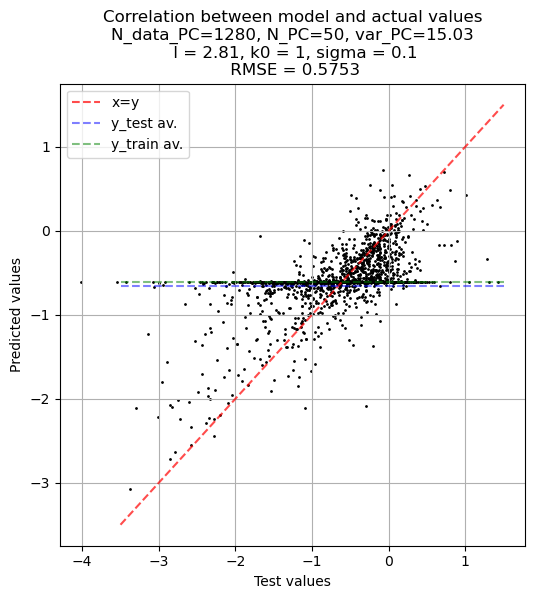

In [49]:
print(f"With l = {opt_params[0]}, k0 = {k0}, sigma = {sigma}  RMSE = {rmse(y_test_values, predictions)}")

xlim = [-3.5, 1.5]
xg = np.linspace(xlim[0], xlim[1], 2)

fig, ax = plt.subplots(figsize=(6,6))

ax.set_title(f'Correlation between model and actual values\nN_data_PC={N_data_PC}, N_PC={n_PC}, var_PC={var_PC:.2f}\n l = {opt_params[0]:.2f}, k0 = {k0}, sigma = {sigma}\n RMSE = {rmse(y_test_values, predictions):.4f}')
ax.plot(xg,xg, color = 'red', linestyle = 'dashed', alpha=0.7, label='x=y')
ax.hlines(np.mean(y_test_values),xmin=xlim[0], xmax=xlim[1], linestyle = 'dashed', color='blue', alpha=0.5, label='y_test av.')
ax.hlines(np.mean(y_train_values),xmin=xlim[0], xmax=xlim[1], linestyle = 'dashed', color='green', alpha=0.5, label='y_train av.')
ax.scatter(y_test_values, predictions, s = 1,color='black')
ax.set_xlabel('Test values')
ax.set_ylabel('Predicted values')
ax.grid()
ax.legend()

print(np.mean(y_test_values))

